In [1]:
#data import
from skimage.io import imread
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#gpu import
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

#model imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.metrics import mean_squared_error

In [2]:
#setup GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

Num GPUs Available:  1


In [3]:
#image processing function
IMG_H = int(170/3)
IMG_W = int(432/3)
#IMG_D = 3
def preprocessImg(img):
    img = img[70:240,0:432] #170,432,3
    h,w,d = img.shape
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.resize(img,(int(w/3),int(h/3)))
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = img/255.0
    return img

In [4]:
#read in track pandas data TRACK
#1. read in full data
steeringData = pd.read_csv('big50day/labeled_data.csv',header=None)
steeringData = steeringData[:]
#2. drop name of frame column
steeringDataNoImg = steeringData.drop(steeringData.columns[0:2],axis=1)
#steeringDataNoImg


#loadin in straight data STRAIGHT
#read in pandas data
#1. read in full data
straightData = pd.read_csv('big100day/labeled_data.csv',header=None)
straightData = straightData[:15000]
#2. drop name of frame column
straightDataNoImg = straightData.drop(straightData.columns[0:2],axis=1)
#straightDataNoImg

In [5]:
#read in images to array + preprocess TRACK
dataDir = 'big50day/frames/'
dataFormat = '.jpg'
dataImages = []
for i in steeringData[0]:
    img = imread('{}{}{}'.format(dataDir,i,dataFormat), as_gray=False)
    img = preprocessImg(img)
    dataImages.append(img)
    
#read in images to array + preprocess STRIAGHT
straightDataDir = 'big100day/frames/'
dataFormat = '.jpg'
straightDataImages = []
for i in straightData[0]:
    img = imread('{}{}{}'.format(straightDataDir,i,dataFormat), as_gray=False)
    img = preprocessImg(img)
    straightDataImages.append(img)

In [6]:
#images to numpy array TRACK
X = np.array(dataImages).reshape(-1,IMG_H,IMG_W,3)
steeringDataNoImg

#images to numpy array STRAIGHT
Z = np.array(straightDataImages).reshape(-1,IMG_H,IMG_W,3)
straightDataNoImg

,2
0,0.00
1,0.00
2,0.00
3,0.00
4,0.00
...,...
14995,-1.00
14996,-1.00
14997,-1.00
14998,-0.91


In [7]:
finalSteering = steeringDataNoImg.append(straightDataNoImg)
for i in finalSteering:
    print(finalSteering)
finalSteering.to_csv('testing.csv',index=False)

          2
0      0.00
1      0.00
2      0.00
3      0.00
4      0.00
...     ...
14995 -1.00
14996 -1.00
14997 -1.00
14998 -0.91
14999 -0.24

[24922 rows x 1 columns]


In [8]:
finalFrames = np.concatenate((X,Z))

In [12]:
#optimizer 
opt = Adam(learning_rate=0.00001)

#model implementation 
model = Sequential()

model.add(Conv2D(36,(3,3),input_shape = finalFrames.shape[1:])) 
model.add(Activation('elu')) 
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(42,(3,3))) 
model.add(Activation('elu')) 
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(48,(3,3))) 
model.add(Activation('elu')) 
model.add(MaxPooling2D(pool_size=(1,1)))

model.add(Conv2D(64,(3,3))) 
model.add(Activation('elu')) 
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,(3,3))) 
model.add(Activation('elu')) 
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())  
model.add(Dense(100))
model.add(Dropout(0.5))
model.add(Dense(50))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Dropout(0.5))

model.add(Dense(1)) 
model.add(Activation('elu'))
#model compil
model.compile(loss='mse', optimizer=opt ,metrics=[mean_squared_error])
hist = model.fit(finalFrames,finalSteering,epochs=500,batch_size=512, validation_split=0.1,verbose=1)

Epoch 1/500
44/44 [==============================] - 4s 81ms/step - loss: 0.4288 - mean_squared_error: 0.4288 - val_loss: 0.1716 - val_mean_squared_error: 0.1716
Epoch 2/500
44/44 [==============================] - 3s 76ms/step - loss: 0.2489 - mean_squared_error: 0.2489 - val_loss: 0.1733 - val_mean_squared_error: 0.1733
Epoch 3/500
44/44 [==============================] - 3s 76ms/step - loss: 0.2360 - mean_squared_error: 0.2360 - val_loss: 0.1723 - val_mean_squared_error: 0.1723
Epoch 4/500
44/44 [==============================] - ETA: 0s - loss: 0.2272 - mean_squared_error: 0.22 - 3s 76ms/step - loss: 0.2271 - mean_squared_error: 0.2271 - val_loss: 0.1665 - val_mean_squared_error: 0.1665
Epoch 5/500
44/44 [==============================] - 3s 76ms/step - loss: 0.2189 - mean_squared_error: 0.2189 - val_loss: 0.1589 - val_mean_squared_error: 0.1589
Epoch 6/500
44/44 [==============================] - 3s 76ms/step - loss: 0.2097 - mean_squared_error: 0.2097 - val_loss: 0.1499 - val_mea

44/44 [==============================] - 3s 76ms/step - loss: 0.0885 - mean_squared_error: 0.0885 - val_loss: 0.0232 - val_mean_squared_error: 0.0232
Epoch 51/500
44/44 [==============================] - 3s 76ms/step - loss: 0.0892 - mean_squared_error: 0.0892 - val_loss: 0.0242 - val_mean_squared_error: 0.0242
Epoch 52/500
44/44 [==============================] - 3s 76ms/step - loss: 0.0843 - mean_squared_error: 0.0843 - val_loss: 0.0225 - val_mean_squared_error: 0.0225
Epoch 53/500
44/44 [==============================] - 3s 76ms/step - loss: 0.0854 - mean_squared_error: 0.0854 - val_loss: 0.0212 - val_mean_squared_error: 0.0212
Epoch 54/500
44/44 [==============================] - 3s 76ms/step - loss: 0.0824 - mean_squared_error: 0.0824 - val_loss: 0.0206 - val_mean_squared_error: 0.0206
Epoch 55/500
44/44 [==============================] - ETA: 0s - loss: 0.0805 - mean_squared_error: 0.0805 ETA: 1s - loss: 0.0 - 3s 76ms/step - loss: 0.0806 - mean_squared_error: 0.0806 - val_loss: 0

Epoch 100/500
44/44 [==============================] - 3s 79ms/step - loss: 0.0560 - mean_squared_error: 0.0560 - val_loss: 0.0164 - val_mean_squared_error: 0.0164
Epoch 101/500
44/44 [==============================] - 3s 76ms/step - loss: 0.0547 - mean_squared_error: 0.0547 - val_loss: 0.0164 - val_mean_squared_error: 0.0164
Epoch 102/500
44/44 [==============================] - 3s 76ms/step - loss: 0.0559 - mean_squared_error: 0.0559 - val_loss: 0.0173 - val_mean_squared_error: 0.0173
Epoch 103/500
44/44 [==============================] - 3s 78ms/step - loss: 0.0555 - mean_squared_error: 0.0555 - val_loss: 0.0164 - val_mean_squared_error: 0.0164
Epoch 104/500
44/44 [==============================] - 4s 85ms/step - loss: 0.0576 - mean_squared_error: 0.0576 - val_loss: 0.0164 - val_mean_squared_error: 0.0164
Epoch 105/500
44/44 [==============================] - 4s 80ms/step - loss: 0.0546 - mean_squared_error: 0.0546 - val_loss: 0.0163 - val_mean_squared_error: 0.0163
Epoch 106/500
44

44/44 [==============================] - 3s 76ms/step - loss: 0.0501 - mean_squared_error: 0.0501 - val_loss: 0.0190 - val_mean_squared_error: 0.0190
Epoch 150/500
44/44 [==============================] - 3s 76ms/step - loss: 0.0511 - mean_squared_error: 0.0511 - val_loss: 0.0168 - val_mean_squared_error: 0.0168
Epoch 151/500
44/44 [==============================] - 3s 77ms/step - loss: 0.0501 - mean_squared_error: 0.0501 - val_loss: 0.0168 - val_mean_squared_error: 0.0168
Epoch 152/500
44/44 [==============================] - 3s 77ms/step - loss: 0.0499 - mean_squared_error: 0.0499 - val_loss: 0.0173 - val_mean_squared_error: 0.0173
Epoch 153/500
44/44 [==============================] - 3s 78ms/step - loss: 0.0495 - mean_squared_error: 0.0495 - val_loss: 0.0175 - val_mean_squared_error: 0.0175
Epoch 154/500
44/44 [==============================] - 3s 77ms/step - loss: 0.0509 - mean_squared_error: 0.0509 - val_loss: 0.0168 - val_mean_squared_error: 0.0168
Epoch 155/500
44/44 [=========

44/44 [==============================] - 4s 80ms/step - loss: 0.0458 - mean_squared_error: 0.0458 - val_loss: 0.0172 - val_mean_squared_error: 0.0172
Epoch 199/500
44/44 [==============================] - 3s 78ms/step - loss: 0.0454 - mean_squared_error: 0.0454 - val_loss: 0.0185 - val_mean_squared_error: 0.0185
Epoch 200/500
44/44 [==============================] - 3s 78ms/step - loss: 0.0446 - mean_squared_error: 0.0446 - val_loss: 0.0171 - val_mean_squared_error: 0.0171
Epoch 201/500
44/44 [==============================] - 3s 78ms/step - loss: 0.0467 - mean_squared_error: 0.0467 - val_loss: 0.0180 - val_mean_squared_error: 0.0180
Epoch 202/500
44/44 [==============================] - 3s 78ms/step - loss: 0.0447 - mean_squared_error: 0.0447 - val_loss: 0.0176 - val_mean_squared_error: 0.0176
Epoch 203/500
44/44 [==============================] - 3s 77ms/step - loss: 0.0460 - mean_squared_error: 0.0460 - val_loss: 0.0175 - val_mean_squared_error: 0.0175
Epoch 204/500
44/44 [=========

Epoch 248/500
44/44 [==============================] - 3s 78ms/step - loss: 0.0436 - mean_squared_error: 0.0436 - val_loss: 0.0177 - val_mean_squared_error: 0.0177
Epoch 249/500
44/44 [==============================] - 3s 78ms/step - loss: 0.0426 - mean_squared_error: 0.0426 - val_loss: 0.0182 - val_mean_squared_error: 0.0182
Epoch 250/500
44/44 [==============================] - 3s 78ms/step - loss: 0.0421 - mean_squared_error: 0.0421 - val_loss: 0.0177 - val_mean_squared_error: 0.0177
Epoch 251/500
44/44 [==============================] - 3s 78ms/step - loss: 0.0443 - mean_squared_error: 0.0443 - val_loss: 0.0198 - val_mean_squared_error: 0.0198
Epoch 252/500
44/44 [==============================] - 3s 77ms/step - loss: 0.0441 - mean_squared_error: 0.0441 - val_loss: 0.0180 - val_mean_squared_error: 0.0180
Epoch 253/500
44/44 [==============================] - 3s 78ms/step - loss: 0.0438 - mean_squared_error: 0.0438 - val_loss: 0.0179 - val_mean_squared_error: 0.0179
Epoch 254/500
44

44/44 [==============================] - 3s 78ms/step - loss: 0.0419 - mean_squared_error: 0.0419 - val_loss: 0.0181 - val_mean_squared_error: 0.0181
Epoch 297/500
44/44 [==============================] - 3s 78ms/step - loss: 0.0417 - mean_squared_error: 0.0417 - val_loss: 0.0186 - val_mean_squared_error: 0.0186
Epoch 298/500
44/44 [==============================] - 3s 78ms/step - loss: 0.0425 - mean_squared_error: 0.0425 - val_loss: 0.0183 - val_mean_squared_error: 0.0183
Epoch 299/500
44/44 [==============================] - 3s 78ms/step - loss: 0.0435 - mean_squared_error: 0.0435 - val_loss: 0.0181 - val_mean_squared_error: 0.0181
Epoch 300/500
44/44 [==============================] - 3s 77ms/step - loss: 0.0405 - mean_squared_error: 0.0405 - val_loss: 0.0185 - val_mean_squared_error: 0.0185
Epoch 301/500
44/44 [==============================] - 3s 78ms/step - loss: 0.0419 - mean_squared_error: 0.0419 - val_loss: 0.0182 - val_mean_squared_error: 0.0182
Epoch 302/500
44/44 [=========

44/44 [==============================] - 3s 78ms/step - loss: 0.0406 - mean_squared_error: 0.0406 - val_loss: 0.0176 - val_mean_squared_error: 0.0176
Epoch 346/500
44/44 [==============================] - 3s 78ms/step - loss: 0.0404 - mean_squared_error: 0.0404 - val_loss: 0.0179 - val_mean_squared_error: 0.0179
Epoch 347/500
44/44 [==============================] - 3s 78ms/step - loss: 0.0411 - mean_squared_error: 0.0411 - val_loss: 0.0182 - val_mean_squared_error: 0.0182
Epoch 348/500
44/44 [==============================] - 3s 78ms/step - loss: 0.0402 - mean_squared_error: 0.0402 - val_loss: 0.0196 - val_mean_squared_error: 0.0196
Epoch 349/500
44/44 [==============================] - 3s 78ms/step - loss: 0.0419 - mean_squared_error: 0.0419 - val_loss: 0.0182 - val_mean_squared_error: 0.0182
Epoch 350/500
44/44 [==============================] - 3s 78ms/step - loss: 0.0406 - mean_squared_error: 0.0406 - val_loss: 0.0187 - val_mean_squared_error: 0.0187
Epoch 351/500
44/44 [=========

44/44 [==============================] - 3s 78ms/step - loss: 0.0394 - mean_squared_error: 0.0394 - val_loss: 0.0181 - val_mean_squared_error: 0.0181: 0.0394 - mean_squared
Epoch 394/500
44/44 [==============================] - 3s 78ms/step - loss: 0.0398 - mean_squared_error: 0.0398 - val_loss: 0.0180 - val_mean_squared_error: 0.0180
Epoch 395/500
44/44 [==============================] - ETA: 0s - loss: 0.0384 - mean_squared_error: 0.03 - 3s 78ms/step - loss: 0.0384 - mean_squared_error: 0.0384 - val_loss: 0.0183 - val_mean_squared_error: 0.0183
Epoch 396/500
44/44 [==============================] - 3s 77ms/step - loss: 0.0392 - mean_squared_error: 0.0392 - val_loss: 0.0179 - val_mean_squared_error: 0.0179
Epoch 397/500
44/44 [==============================] - ETA: 0s - loss: 0.0386 - mean_squared_error: 0.03 - 3s 77ms/step - loss: 0.0386 - mean_squared_error: 0.0386 - val_loss: 0.0188 - val_mean_squared_error: 0.0188
Epoch 398/500
44/44 [==============================] - 3s 77ms/step

44/44 [==============================] - 4s 82ms/step - loss: 0.0391 - mean_squared_error: 0.0391 - val_loss: 0.0179 - val_mean_squared_error: 0.0179
Epoch 443/500
44/44 [==============================] - 3s 78ms/step - loss: 0.0371 - mean_squared_error: 0.0371 - val_loss: 0.0201 - val_mean_squared_error: 0.0201
Epoch 444/500
44/44 [==============================] - 3s 78ms/step - loss: 0.0385 - mean_squared_error: 0.0385 - val_loss: 0.0177 - val_mean_squared_error: 0.0177
Epoch 445/500
44/44 [==============================] - 4s 83ms/step - loss: 0.0385 - mean_squared_error: 0.0385 - val_loss: 0.0179 - val_mean_squared_error: 0.0179
Epoch 446/500
44/44 [==============================] - 4s 84ms/step - loss: 0.0385 - mean_squared_error: 0.0385 - val_loss: 0.0183 - val_mean_squared_error: 0.0183
Epoch 447/500
44/44 [==============================] - 4s 80ms/step - loss: 0.0388 - mean_squared_error: 0.0388 - val_loss: 0.0179 - val_mean_squared_error: 0.0179
Epoch 448/500
44/44 [=========

Epoch 492/500
44/44 [==============================] - 3s 78ms/step - loss: 0.0384 - mean_squared_error: 0.0384 - val_loss: 0.0181 - val_mean_squared_error: 0.0181
Epoch 493/500
44/44 [==============================] - ETA: 0s - loss: 0.0380 - mean_squared_error: 0.03 - 3s 78ms/step - loss: 0.0380 - mean_squared_error: 0.0380 - val_loss: 0.0177 - val_mean_squared_error: 0.0177
Epoch 494/500
44/44 [==============================] - 4s 81ms/step - loss: 0.0358 - mean_squared_error: 0.0358 - val_loss: 0.0179 - val_mean_squared_error: 0.0179
Epoch 495/500
44/44 [==============================] - 3s 79ms/step - loss: 0.0369 - mean_squared_error: 0.0369 - val_loss: 0.0177 - val_mean_squared_error: 0.0177
Epoch 496/500
44/44 [==============================] - 4s 80ms/step - loss: 0.0392 - mean_squared_error: 0.0392 - val_loss: 0.0180 - val_mean_squared_error: 0.0180
Epoch 497/500
44/44 [==============================] - 3s 79ms/step - loss: 0.0373 - mean_squared_error: 0.0373 - val_loss: 0.01

Text(0.5, 1.0, 'loss over time')

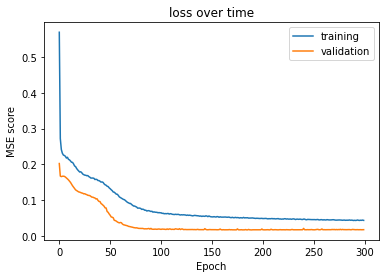

In [10]:
#plotting results
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['training', 'validation'])
plt.ylabel('MSE score')
plt.xlabel('Epoch')
plt.title('loss over time')

In [13]:
model.save('md500.h5')